In [196]:
%matplotlib notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

In [197]:
df = pd.read_csv('data/enterprise_saas_v3.csv')
df = df.set_index('ticker')

df_y = pd.DataFrame(df['px_chg'], columns=['px_chg'], index=df.index.values)
df_x = df.drop(columns=['px_chg', 'ev_chg', 'eqy_c', 'ev_c', 'sales2_ev', 'salesh_ev', 'ebitda2_ev', 'net_debt_ev', 'sales_chg_ltm'])
df_x.head()

,val_trade,si_ratio,sales_ev,ebitda_ev,debt_ev,sales_chg_fwd,sales_chg_2fwd,sales_chg_qoq,ebitda_chg_fwd,ebitda_chg_2fwd
ticker,,,,,,,,,,
CRWD US Equity,2.420991e+08,0.01263,33.831879,-0.004472,0.000000,0.801268,0.420889,0.125222,0.003506,0.002014
SIM DC Equity,5.037642e+07,0.00000,7.368594,0.041165,0.014198,0.186864,0.078448,0.098198,0.008512,0.003138
WLN FP Equity,2.124141e+07,0.00000,4.748411,0.052351,0.034626,0.374679,0.072148,0.058613,0.025563,0.007550
NRO FP Equity,7.841901e+04,0.00000,0.742148,0.162927,0.001321,0.040657,0.046406,-0.027972,0.021086,0.007398
CGM FP Equity,7.357188e+05,0.00000,1.009947,0.161968,0.379215,0.055725,0.040506,-0.092072,0.035435,0.011547


In [280]:
scaler = StandardScaler()
X_norm = scaler.fit_transform(df_x.values)
Y_norm = scaler.fit_transform(df_y.values)
df_x_norm = pd.DataFrame(X_norm, columns=df_x.columns, index=df_x.index.values)
df_x_norm.head()

,val_trade,si_ratio,sales_ev,ebitda_ev,debt_ev,sales_chg_fwd,sales_chg_2fwd,sales_chg_qoq,ebitda_chg_fwd,ebitda_chg_2fwd
CRWD US Equity,0.133477,-0.706400,4.902271,-1.259352,-0.794329,3.947582,3.101285,0.627857,-0.668427,-0.840961
SIM DC Equity,-0.202098,-0.926289,0.194171,-0.183286,-0.695333,0.174014,-0.609481,0.382934,-0.478862,-0.720926
WLN FP Equity,-0.253093,-0.926289,-0.271988,0.080456,-0.552904,1.327540,-0.677739,0.024170,0.166870,-0.249650
NRO FP Equity,-0.290135,-0.926289,-0.984745,2.687655,-0.785118,-0.723965,-0.956691,-0.760563,-0.002655,-0.265931
CGM FP Equity,-0.288985,-0.926289,-0.937100,2.665046,1.849718,-0.631419,-1.020620,-1.341512,0.540745,0.177244


In [318]:
pca = PCA(n_components=4)
pca.fit(X_norm)
pca.explained_variance_ratio_

array([0.33394413, 0.14025382, 0.10533683, 0.09884977])

In [319]:
df_comps = pd.DataFrame(pca.components_, columns=df_x.columns)
df_comps

,val_trade,si_ratio,sales_ev,ebitda_ev,debt_ev,sales_chg_fwd,sales_chg_2fwd,sales_chg_qoq,ebitda_chg_fwd,ebitda_chg_2fwd
0,0.040158,-0.028525,0.453802,-0.425982,-0.325902,0.432921,0.490578,0.156136,-0.196823,-0.112960
1,-0.291115,0.519948,-0.078589,-0.111554,0.350283,0.193587,0.187406,0.381506,0.279831,0.455124
2,0.595451,-0.413837,-0.209875,0.021683,0.028964,0.061540,0.125373,0.235278,-0.099465,0.586571
3,0.494503,0.058631,0.218318,0.227695,0.267050,0.065369,0.030833,0.366043,0.451731,-0.487784


In [323]:
cluster_counts = []
steps = 20
eps = np.linspace(0.5, 1.5, num=steps)
for i in range(steps):
    clusters = DBSCAN(eps=eps[i], min_samples=4).fit(X_pca)
    cluster_counts.append(len(set(clusters.labels_)))

plt.clf()
plt.plot(eps, cluster_counts, 'ro')
plt.xlabel('eps')
plt.ylabel('clusters')
plt.show()

In [324]:
X_pca = pca.transform(X_norm)
clustering = DBSCAN(eps=0.7, min_samples=4).fit(X_pca)
print(len(set(clustering.labels_)))
X_pca[:3]

coefs = np.corrcoef(np.concatenate((X_pca, Y_norm), axis=1), rowvar=False)
coefs[-1, :-1]

4


array([-0.38425225,  0.25706854,  0.17368732, -0.17403069])

<IPython.core.display.Javascript object>


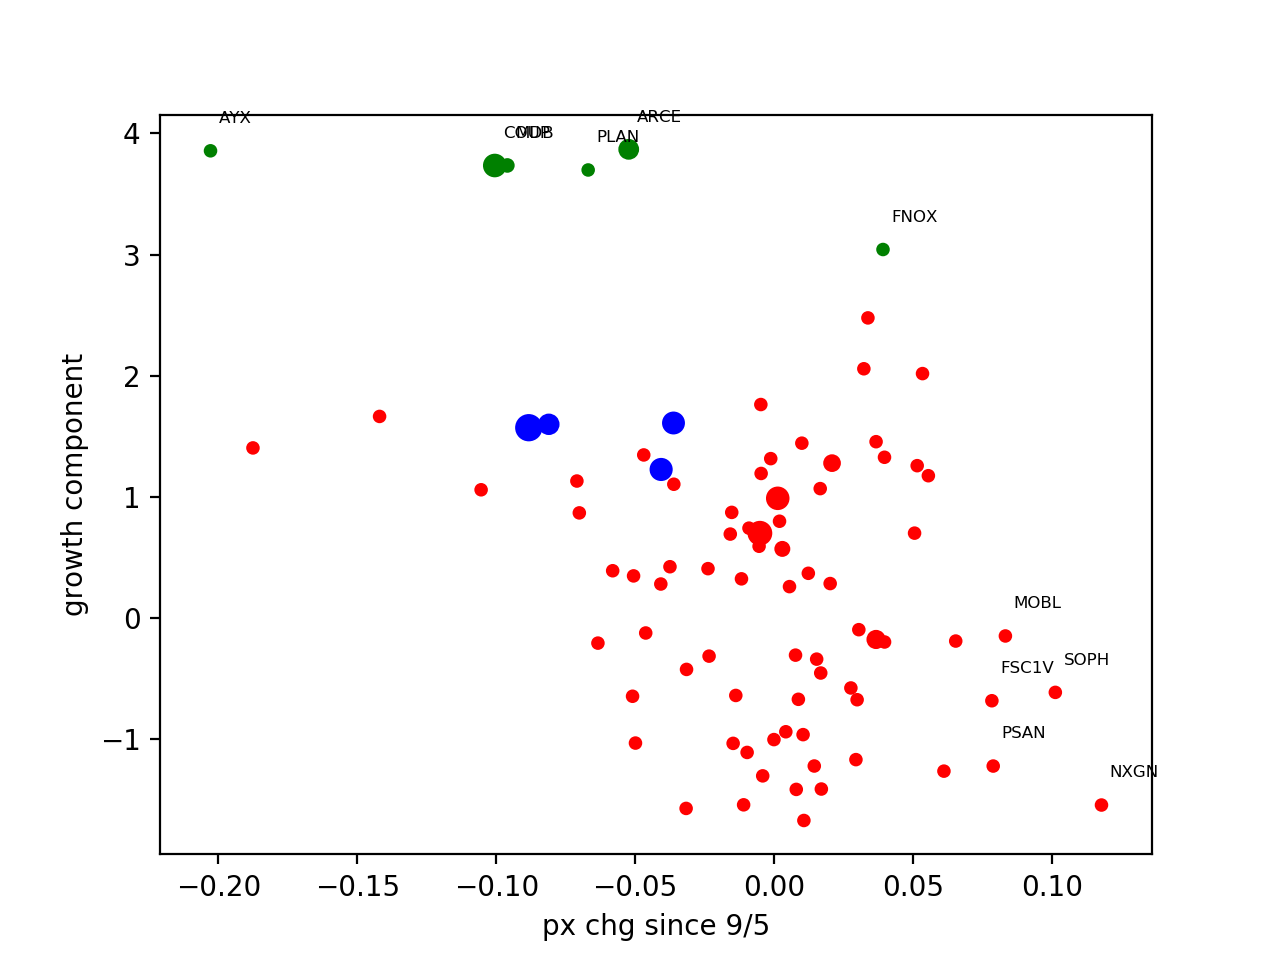

In [325]:
plt.clf()
s = [max(10, v*100) for v in X_pca[:, 2]]
colors = ['red', 'green', 'blue', 'magenta', 'cyan', 'black', 'yellow']
c = [colors[l] for l in clustering.labels_]
plt.scatter(X_pca[:,0], X_pca[:,1], c=c, s=s)
for i, pt in enumerate(X_pca):
    if clustering.labels_[i] == 1:
       plt.annotate(df_x.index[i].split(' ')[0], xy=(pt[0], pt[1]), xytext=(3, 10), textcoords='offset points', fontsize=6)
plt.show()

In [338]:
plt.clf()
neigh_idxs = np.where(clustering.labels_ != -1)
X_neigh = X_pca[neigh_idxs]
yidx = 0
yidx2 = 1
s = [max(15, v*100) for v in X_neigh[:, yidx2]]
c = [colors[i] for i in clustering.labels_[neigh_idxs]]
plt.scatter(df_y['px_chg'].values[neigh_idxs], X_neigh[:, yidx], c=c, s=s)
for i, idx in enumerate(df_x.index.values[neigh_idxs]):
   if df_y.loc[idx, 'px_chg'] > 0.075 or clustering.labels_[neigh_idxs][i] == 1:
       plt.annotate(idx.split(' ')[0], xy=(df_y.loc[idx, 'px_chg'], X_neigh[i, yidx]), xytext=(3, 10), textcoords='offset points',fontsize=6)
plt.xlabel('px chg since 9/5')
plt.ylabel('growth component')
plt.show()